# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Arguments" data-toc-modified-id="Arguments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arguments</a></div><div class="lev1 toc-item"><a href="#MetaCyc-subset-of-QM9" data-toc-modified-id="MetaCyc-subset-of-QM9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MetaCyc subset of QM9</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-compounds-to-reactions" data-toc-modified-id="Delta-G^\circ_{QM9}-compounds-to-reactions-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ compounds to reactions</a></div><div class="lev1 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Define-model-and-optimizer" data-toc-modified-id="Define-model-and-optimizer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define model and optimizer</a></div><div class="lev1 toc-item"><a href="#Create-model" data-toc-modified-id="Create-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create model</a></div><div class="lev1 toc-item"><a href="#get-the-best-checkpoint-if-available-without-training" data-toc-modified-id="get-the-best-checkpoint-if-available-without-training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>get the best checkpoint if available without training</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(GCM)" data-toc-modified-id="Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(GCM)-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>$\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}(GCM)$</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(MPNNv2,chemgraph)" data-toc-modified-id="Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(MPNNv2,chemgraph)-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>$\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)</a></div>

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd

import time
import argparse
import os
import numpy as np
import sys
sys.path.append(os.getcwd())
# Our Modules
import utils
from utils import datasets
from models.MPNN import MPNN
from models.MPNNv2 import MPNNv2
from models.MPNNv3 import MPNNv3
from utils.LogMetric import AverageMeter, Logger


# Arguments

In [2]:
parser = argparse.ArgumentParser(description='Neural message passing')

parser.add_argument('--dataset', default='qm9', help='QM9')
parser.add_argument('--edge-rep', default='raw_distance', choices=['raw_distance','chem_graph','distance_bin'] )
parser.add_argument('--datasetPath', default='./mpnn-data/qm9/dsgdb9nsd/', help='dataset path')
parser.add_argument('--logPath', default='./log/qm9/mpnn/', help='log path')
parser.add_argument('--plotLr', default=False, help='allow plotting the data')
parser.add_argument('--plotPath', default='./plot/qm9/mpnn/', help='plot path')
parser.add_argument('--resume', default='./checkpoint/qm9/mpnn/',
                    help='path to latest checkpoint')
# Optimization Options
parser.add_argument('--batch-size', type=int, default=3200, metavar='N',
                    help='Input batch size for training (default: 20)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Enables CUDA training')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='Number of epochs to train (default: 50)')
parser.add_argument('--lr', type=lambda x: restricted_float(x, [1e-5, 1e-2]), default=1e-3, metavar='LR',
                    help='Initial learning rate [1e-5, 5e-4] (default: 1e-4)')
parser.add_argument('--lr-decay', type=lambda x: restricted_float(x, [.01, 1]), default=0.6, metavar='LR-DECAY',
                    help='Learning rate decay factor [.01, 1] (default: 0.6)')
parser.add_argument('--schedule', type=list, default=[0.1, 0.9], metavar='S',
                    help='Percentage of epochs to start the learning rate decay [0, 1] (default: [0.1, 0.9])')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
# i/o
parser.add_argument('--log-interval', type=int, default=20, metavar='N',
                    help='How many batches to wait before logging training status')
# Accelerating
parser.add_argument('--prefetch', type=int, default=2, help='Pre-fetching threads.')

# Model modification
parser.add_argument('--model', type=str,help='MPNN model name [MPNN, MPNNv2, MPNNv3]',
                        default='MPNN')


args = parser.parse_args(['--model','MPNNv2', '--edge-rep','chem_graph','--no-cuda'])
print(args)


Namespace(batch_size=3200, dataset='qm9', datasetPath='./mpnn-data/qm9/dsgdb9nsd/', edge_rep='chem_graph', epochs=50, logPath='./log/qm9/mpnn/', log_interval=20, lr=0.001, lr_decay=0.6, model='MPNNv2', momentum=0.9, no_cuda=True, plotLr=False, plotPath='./plot/qm9/mpnn/', prefetch=2, resume='./checkpoint/qm9/mpnn/', schedule=[0.1, 0.9])


In [3]:
def restricted_float(x, inter):
    x = float(x)
    if x < inter[0] or x > inter[1]:
        raise argparse.ArgumentTypeError("%r not in range [1e-5, 1e-4]"%(x,))
    return x


In [4]:

best_er1 = 0

    # Check if CUDA is enabled
args.cuda = not args.no_cuda and torch.cuda.is_available()

    # Load data
root = args.datasetPath
root

'./mpnn-data/qm9/dsgdb9nsd/'

# MetaCyc subset of QM9

In [ ]:
print('Prepare files')
import pandas as pd
qm9_metacyc = pd.read_table('Dataset/QM9_metacyc.tab')
qm9_metacyc

## Read all files, split into train, test, validation sets

In [ ]:
files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

idx = np.random.permutation(len(files))
idx = idx.tolist()

In [6]:
valid_ids = [files[i] for i in idx[0:10000]]
test_ids = [files[i] for i in idx[10000:20000]]
train_ids = [files[i] for i in idx[20000:]]

data_train = utils.Qm9(root, train_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_valid = utils.Qm9(root, valid_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_test = utils.Qm9(root, test_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)

print('\tStatistics')
stat_dict_valid = datasets.get_graph_stats(data_valid, ['target_mean', 'target_std'], multiprocess_p=True)

mean_dG, std_dG = stat_dict_valid['target_mean'][-2], stat_dict_valid['target_std'][-2]
mean_dG, std_dG

	Statistics


(-411.22491278479896, 40.921979528310374)

In [ ]:
print('Define model')
# Select one graph
g_tuple, l = data_train[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(data_valid, 0, len(data_valid), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

In [ ]:
data_train.set_target_transform(lambda x: datasets.normalize_data(x,stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_valid.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_test.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                           stat_dict_valid['target_std']))

In [ ]:
    train_loader = torch.utils.data.DataLoader(data_train,
                                               batch_size=args.batch_size, shuffle=True,
                                               collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(data_valid,
                                               batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                              num_workers=args.prefetch, pin_memory=True)


# $\Delta G^\circ_{MetaCyc}$ compounds

In [7]:
metacyc_root = 'Dataset/MetaCyc'
metacyc_xyz = [m for m in sorted(os.listdir(metacyc_root)) 
               if '.xyz' == m[-4:]]
metacyc_graphs = utils.Qm9(metacyc_root,
                               metacyc_xyz,
                               edge_transform=datasets.qm9_edges, 
                               e_representation=args.edge_rep )
metacyc_graphs

In [ ]:
g, target = utils.graph_reader.xyz_graph_reader()
g

In [ ]:
graph_file = os.path.join(metacyc_root, metacyc_graphs.ids[1])
from utils.graph_reader import init_graph
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig

with open(graph_file,'r') as f:
        # Number of atoms
        na = int(f.readline())

        # Graph properties
        properties = f.readline()
        g, l = init_graph(properties)
        
        atom_properties = []
        # Atoms properties
        for i in range(na):
            a_properties = f.readline()
            a_properties = a_properties.replace('.*^', 'e')
            a_properties = a_properties.replace('*^', 'e')
            a_properties = a_properties.split()
            atom_properties.append(a_properties)
        print(atom_properties)
        # Frequencies
        f.readline()

        # SMILES
        smiles = f.readline()
        smiles = smiles.split()
        smiles = smiles[0]
        
        m = Chem.MolFromSmiles(smiles)
        m = Chem.AddHs(m)

        fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        factory = ChemicalFeatures.BuildFeatureFactory(fdef_name)
        feats = factory.GetFeaturesForMol(m)

        # Create nodes
        for i in range(0, m.GetNumAtoms()):
            atom_i = m.GetAtomWithIdx(i)

            g.add_node(i, a_type=atom_i.GetSymbol(), a_num=atom_i.GetAtomicNum(), acceptor=0, donor=0,
                       aromatic=atom_i.GetIsAromatic(), hybridization=atom_i.GetHybridization(),
                       num_h=atom_i.GetTotalNumHs(), coord=np.array(atom_properties[i][1:4]).astype(np.float),
                       pc=float(atom_properties[i][4]))


In [ ]:
m.GetNumAtoms()

In [ ]:
metacyc_graphs.ids[1]

In [28]:
import pandas as pd
metacyc_vals = utils.datasets.get_values(metacyc_graphs, 
                                             0, 
                                             len(metacyc_graphs), 
                                             ['target_mean','target_std'])
metacyc_param = np.array([file_res['params'] for file_res in metacyc_vals])
metacyc_GCM_dG = pd.Series(metacyc_param[:,-2], 
                           index=[m[:-4] for m in metacyc_xyz])
metacyc_GCM_dG.to_csv('Dataset/MetaCyc_GCM.deltaG0f.tab',index=True, sep='\t')
metacyc_GCM_dG

1-3-7-TRIMETHYLXANTHINE                   304.855470
1-4-HYDROXYPHENYL-2-METHYLAMINOETHAN      431.385588
1-7-DIMETHYLXANTHINE                      167.569074
1-AMINO-PROPAN-2-OL                       241.413210
1-CARBOXYGLUTAMIC_ACID                   -724.335754
1-DEOXYNOJIRIMYCIN                          6.876917
1-DEOXYXYLONOJIRIMYCIN                     80.840679
1-ETHYLADENINE                            742.158338
1-INDANOL                                 442.128301
1-INDANONE                                377.141409
1-KETO-2-METHYLVALERATE                  -196.270369
1-METHYL-MYO-INOSITOL                    -257.375902
12-DIHYDROXY-6-METHYLCYCLOHEXA-35-DIEN   -168.330562
1235-TETRAHYDROXYBENZENE                 -279.128322
13-DINITROBENZENE                        -236.377247
15-ANHYDRO-D-FRUCTOSE                    -289.402301
15-ANHYDRO-D-GLUCITOL                    -230.900559
15-DIDEOXY-15-IMINO-D-GALACTITOL            6.876917
17-DIAMINOHEPTANE                         849.

## $\Delta G^\circ_{QM9}$ compounds to reactions

In [ ]:
qm9_metacyc_dict = qm9_metacyc.set_index('cpd').to_dict()['FrameId']
qm9_metacyc_dict

In [ ]:
metacyc_files = [( qm9_metacyc_dict['./' + os.path.basename(f)], f ) 
                     for f in os.listdir(root) 
                         if os.path.isfile(os.path.join(root, f))
                            and 
                            './' + os.path.basename(f) 
                            in qm9_metacyc_dict]
dict(metacyc_files)

In [ ]:
qm9_metacyc_graphs = utils.Qm9(root,
                               sorted([f[2:] for f in qm9_metacyc_dict.keys()]),
                               edge_transform=datasets.qm9_edges, 
                               e_representation=args.edge_rep )
qm9_metacyc_vals = utils.datasets.get_values(qm9_metacyc_graphs, 
                                             0, 
                                             len(qm9_metacyc_graphs), 
                                             ['target_mean','target_std'])
qm9_metacyc_param = np.array([file_res['params'] for file_res in qm9_metacyc_vals])
qm9_metacyc_dG = pd.Series(qm9_metacyc_param[:,-2], 
                           index=[qm9_metacyc_dict[f] 
                                  for f in sorted(qm9_metacyc_dict)])
qm9_metacyc_dG.to_csv('Dataset/QM9_DFT_deltaG0f.tab',index=True, sep='\t')
qm9_metacyc_dG

In [ ]:
qm9_metacyc_dG_min = qm9_metacyc_dG.reset_index().groupby('index').min().dropna()
qm9_metacyc_dG_min.columns = ['$\Delta G^\circ_f(DFT)$']
qm9_metacyc_dG_min

In [ ]:
stoich_matrix = pd.read_table('Dataset/QM9.S',index_col=['Rxn','Metabolite'])['Stoichiometry']
rxns, metabs = stoich_matrix.index.levels
stoich_dict = stoich_matrix.to_dict()
S = pd.DataFrame(0,index=metabs, columns=rxns)
for rxn,metab in stoich_dict:   
    S.loc[metab,rxn] = stoich_dict[rxn, metab]
#S.loc['3-HYDROXY-4H-PYRID-4-ONE','CREATINASE-RXN'] = 1
S

In [ ]:
deltaG = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG

In [ ]:
deltaG

# Statistics

In [ ]:
print('\tStatistics')
stat_dict = datasets.get_graph_stats(qm9_metacyc_graphs, ['target_mean', 'target_std'], multiprocess_p=True)
stat_dict

# Define  metacyc model and optimizer


In [8]:
print('Define model')
# Select one graph
g_tuple, l = metacyc_graphs[0]
g, h_t, e = g_tuple

Define model


In [ ]:
vals = utils.datasets.get_values(metacyc_graphs, 0, len(metacyc_graphs), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

In [ ]:
len(metacyc_graphs)

In [10]:
metacyc_predict_loader = torch.utils.data.DataLoader(   metacyc_graphs,
                                                batch_size=args.batch_size,
                                                shuffle=False,
                                                collate_fn=datasets.collate_g,
                                                num_workers=args.prefetch,
                                                pin_memory=False)
#for i, batch_sample in enumerate(metacyc_predict_loader):
#    print(i, batch_sample)

# Define QM9 metacyc model and optimizer


In [ ]:
print('Define model')
# Select one graph
g_tuple, l = qm9_metacyc_graphs[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(qm9_metacyc_graphs, 0, len(qm9_metacyc_graphs), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

In [ ]:
len(qm9_metacyc_graphs)

In [ ]:
predict_loader = torch.utils.data.DataLoader(   qm9_metacyc_graphs,
                                                batch_size=len(qm9_metacyc_graphs),
                                                shuffle=False,
                                                collate_fn=datasets.collate_g,
                                                num_workers=args.prefetch,
                                                pin_memory=True)
#for i, batch_sample in enumerate(predict_loader):
#    print(i, batch_sample)

# Create MPNNv2 with chem_graph edge attributes model

In [11]:
    in_n = [len(h_t[0]), len(list(e.values())[0])]
    hidden_state_size = 73
    message_size = 73
    n_layers = 3
    l_target = len(l)
    type ='regression'
    if args.model == 'MPNNv2':
        model = MPNNv2(in_n, [5, 15, 15], [10, 20, 20], l_target, type=type)
    elif args.model == 'MPNNv3':
        model = MPNNv3([1, 2, 3, 4], in_n, [5, 15, 15], 30, l_target, type=type)
    else:
        model = MPNN(in_n, hidden_state_size, message_size, n_layers, l_target, type=type)
    del in_n, hidden_state_size, message_size, n_layers, l_target, type

In [12]:
    print('Optimizer')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.MSELoss()

    evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))

    print('Logger')
    logger = Logger(args.logPath)

    lr_step = (args.lr-args.lr*args.lr_decay)/(args.epochs*args.schedule[1] - args.epochs*args.schedule[0])

Optimizer
Logger


# get the best checkpoint if available without training

In [13]:
if args.resume:
        checkpoint_dir = args.resume
        best_model_file = os.path.join(checkpoint_dir, 'model_best.pth')
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        if os.path.isfile(best_model_file):
            print("=> loading best model '{}'".format(best_model_file))
            checkpoint = torch.load(best_model_file)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_er1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded best model '{}' (epoch {})".format(best_model_file, checkpoint['epoch']))
        else:
            print("=> no best model found at '{}'".format(best_model_file))


=> loading best model './checkpoint/qm9/mpnn/model_best.pth'
=> loaded best model './checkpoint/qm9/mpnn/model_best.pth' (epoch 50)


In [14]:
    print('Check cuda')
    if args.cuda:
        print('\t* Cuda')
        model = model.cuda()
        criterion = criterion.cuda()


Check cuda


# $\Delta G^\circ_{MPNNv2}$ vs $\Delta G^\circ_{GCM}$

In [15]:
def predict(val_loader, model, logger=None):
    batch_time = AverageMeter()
    output = []
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, batch_sample in enumerate(val_loader):
        if len(batch_sample) >= 3:
            g,h,e = batch_sample[0], batch_sample[1], batch_sample[2]
            if i >= 0:
                print("Iteration: {}".format(i))
                print("Graph: {}".format(g.size()))
                print("Hidden units: {}".format(h.size()))
                print("Edges: {}".format(e.size()))
        # Prepare input data
        if args.cuda:
            g, h, e = g.cuda(), h.cuda(), e.cuda()
        g, h, e = Variable(g), Variable(h), Variable(e)

        # Compute output
        output.append( model(g, h, e) )



        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return output


In [16]:
output = predict( metacyc_predict_loader, model )

Iteration: 0
Graph: torch.Size([3028, 36, 36])
Hidden units: torch.Size([3028, 36, 13])
Edges: torch.Size([3028, 36, 36, 1])


In [ ]:
(output[0][:,-2].data).cpu().numpy()

In [ ]:
import pandas as pd
normalized_dG_MPNN = pd.DataFrame({r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$':(output[0][:,-2].data).cpu().numpy()}, 
                      index=[qm9_metacyc_dict[f] 
                            for f in sorted(qm9_metacyc_dict)]).reset_index().groupby('index').min()
normalized_dG_MPNN

In [23]:
std_dG, mean_dG

(40.921979528310374, -411.22491278479896)

In [22]:
normalized_dG_MPNN_metacyc = pd.DataFrame({r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$':(output[0][:,-2].data).cpu().numpy()}, 
                      index=[m[:-4]
                            for m in metacyc_xyz]) #.reset_index().groupby('index').min()
normalized_dG_MPNN_metacyc['$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$'] = normalized_dG_MPNN_metacyc[r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$']*std_dG + mean_dG

normalized_dG_MPNN_metacyc['$\Delta G^\circ_{GCM}$'] = metacyc_GCM_dG
normalized_dG_MPNN_metacyc.to_csv('Dataset/MetaCyc_dG_MPNN_vs_GCM_cpds.csv',sep='\t')
normalized_dG_MPNN_metacyc

NameError: name 'metacyc_GCM_dG' is not defined

In [24]:
dG_MPNN_metacyc = pd.read_table('Dataset/MetaCyc_dG_MPNN_vs_GCM_cpds.csv',index_col=0)
dG_MPNN_metacyc

,$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$,"$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$",$\Delta G^\circ_{GCM}$
1-3-7-TRIMETHYLXANTHINE,-1.644738,-478.530853,304.855470
1-4-HYDROXYPHENYL-2-METHYLAMINOETHAN,-0.674959,-438.845581,431.385588
1-7-DIMETHYLXANTHINE,-1.565857,-475.302887,167.569074
1-AMINO-PROPAN-2-OL,3.965199,-248.961121,241.413210
1-CARBOXYGLUTAMIC_ACID,-4.319189,-587.974670,-724.335754
1-DEOXYNOJIRIMYCIN,-2.448666,-511.429199,6.876917
1-DEOXYXYLONOJIRIMYCIN,-1.542087,-474.330170,80.840679
1-ETHYLADENINE,-0.261497,-421.925903,742.158338
1-INDANOL,0.585542,-387.263397,442.128301
1-INDANONE,0.708526,-382.230621,377.141409


In [1]:
%matplotlib inline
#alt.Chart(normalized_dG_MPNN_metacyc).mark_point().encode(
#    x='$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$',
#    y='$\Delta G^\circ_{GCM}$')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
dG_MPNN_metacyc.plot(x='$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$',
            y='$\Delta G^\circ_{GCM}$',
            kind='scatter',
            title=r'$\Delta G^\circ_{GCM}$ vs $\Delta G^\circ_{MPNN}$ ($\frac{kJ}{mol}$)',
           )#xlim=[-0.1,0.1])

identity_line = np.linspace(max(dG_MPNN_metacyc['$\Delta G^\circ_{GCM}$'].min(), 
                                dG_MPNN_metacyc['$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$'].min()),
                            min(dG_MPNN_metacyc['$\Delta G^\circ_{GCM}$'].max(), 
                                dG_MPNN_metacyc['$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_MPNN_cpds.png')

NameError: name 'dG_MPNN_metacyc' is not defined

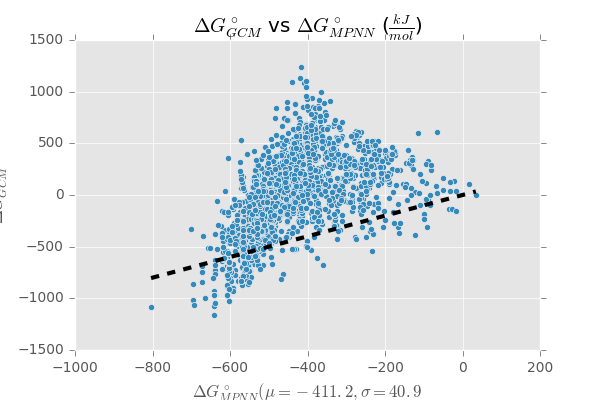

In [1]:
from IPython.display import Image
Image('Dataset/GCM_vs_MPNN_cpds.png')

## $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph) vs $\Delta G^\circ_{rxn}$(GCN)

In [28]:
stoich_matrix = pd.read_table('Dataset/friendly-metacyc-rxns.S',index_col=['Rxn','Metabolite'])['Stoichiometry']
rxns, metabs = stoich_matrix.index.levels
stoich_dict = stoich_matrix.to_dict()
S = pd.DataFrame(0,index=metabs, columns=rxns)
for rxn,metab in stoich_dict:   
    S.loc[metab,rxn] = stoich_dict[rxn, metab]
#S.loc['3-HYDROXY-4H-PYRID-4-ONE','CREATINASE-RXN'] = 1
S

Rxn,1.1.3.37-RXN,1.1.3.38-RXN,1.1.3.40-RXN,1.1.3.41-RXN,1.1.99.28-RXN,1.13.11.14-RXN,1.13.11.15-RXN,1.13.11.16-RXN,1.13.11.28-RXN,1.13.11.41-RXN,...,URONOLACTONASE-RXN,URUR-RXN,VAGL-RXN,VALGLU-RXN,VALINE-DECARBOXYLASE-RXN,VALINE-PYRUVATE-AMINOTRANSFER-RXN,XANTHINE-OXIDASE-RXN,XYLISOM-RXN,XYLONATE-DEHYDRATASE-RXN,XYLONO-14-LACTONASE-RXN
Metabolite,,,,,,,,,,,,,,,,,,,,,
1-3-7-TRIMETHYLXANTHINE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-4-HYDROXYPHENYL-2-METHYLAMINOETHAN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-7-DIMETHYLXANTHINE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1-KETO-2-METHYLVALERATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12-EPOXYPROPANE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235-TETRAHYDROXYBENZENE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15-ANHYDRO-D-FRUCTOSE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-3-DIHYDROXYBENZOATE,0,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
2-3-DIHYDROXYPHENYL-PROPIONATE,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
missing_cpds = set(metabs) - set(normalized_dG_MPNN_metacyc.index)
rxns_of_missing_cpds = set([rxn for rxn in rxns if (S.loc[ missing_cpds, rxn] != 0).any()])
len(missing_cpds), len(rxns_of_missing_cpds)
metabs_f, rxns_f  = set(metabs) - missing_cpds, set(rxns) - rxns_of_missing_cpds


In [44]:
deltaG = S.loc[metabs_f, rxns_f].T.\
           dot( dG_MPNN_metacyc['$\Delta G^\circ_{MPNN}(\mu=-411.2,\sigma=40.9$'][metabs_f]).\
           to_frame('$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)')
deltaG['$\Delta G^\circ_{rxn}$(GCN)'] = S.loc[metabs_f, rxns_f].T.\
           dot( dG_MPNN_metacyc['$\Delta G^\circ_{GCM}$'][metabs_f])
deltaG

,"$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)",$\Delta G^\circ_{rxn}$(GCN)
Rxn,,
RXN-10739,17.509705,-117.110147
CREATININE-DEAMINASE-RXN,-110.317383,-28.547433
RXN-11318,-26.979065,-64.505295
2-AMINOHEXANOATE-AMINOTRANSFERASE-RXN,-5.500061,5.540085
6-METHYLSALICYLATE-DECARBOXYLASE-RXN,-49.516937,2.192967
2.6.1.72-RXN,0.558807,-11.237807
PHENYLPYRUVATE-TAUTOMERASE-RXN,5.499023,20.710787
CATAL-RXN,44.844666,-190.179511
AMACETOXID-RXN,-39.182526,-89.968581


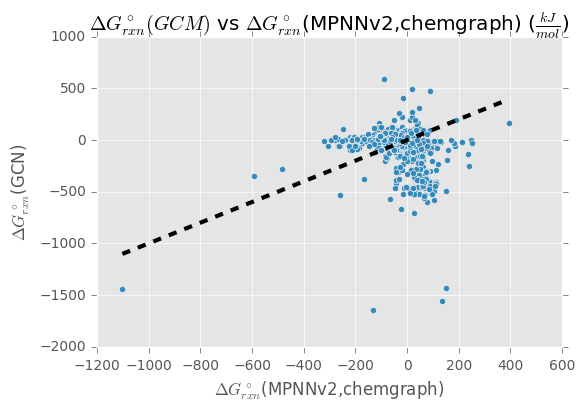

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
#friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')
#deltaG['$\Delta G^\circ_{rxn}(GCM)$'] = friendly_rxns.loc[rxns,'dG']*4.184
deltaG.plot(y='$\Delta G^\circ_{rxn}$(GCM)',
            x='$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}(GCM)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph) ($\frac{kJ}{mol}$)',
           )#xlim=[-0.1,0.1])

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}$(GCM)'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}$(GCM)'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_MPNNv2_chemgraph_rxns.png')

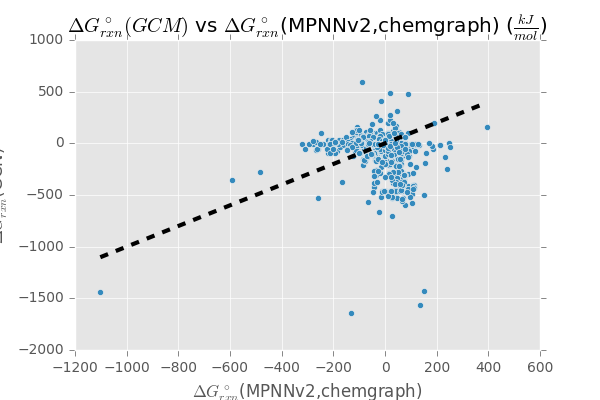

In [2]:
Image('Dataset/GCM_vs_MPNNv2_chemgraph_rxns.png')

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr = lr.fit(normalized_dG_MPNN, qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'] )
linear_params= lr.get_params()

In [ ]:
mu, sigma =  lr.intercept_, lr.coef_
qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'] = normalized_dG_MPNN*sigma + mu
qm9_metacyc_dG_min.to_csv('Dataset/deltaG_DFT_vs_MPNNv2_chemgraph_metabolites.tab',sep='\t')

In [ ]:
qm9_metacyc_dG_min = pd.read_table('Dataset/deltaG_DFT_vs_MPNNv2_chemgraph_metabolites.tab',
                                   index_col='index')
qm9_metacyc_dG_min

In [ ]:
deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'] = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG.to_csv('Dataset/deltaG_DFT_vs_GCM_vs_MPNNv2_chemgraph_rxns.tab',sep='\t')

In [ ]:
deltaG = pd.read_table('Dataset/deltaG_DFT_vs_GCM_vs_MPNNv2_chemgraph_rxns.tab',index_col='Rxn')
deltaG

## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}(GCM)$

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')
deltaG['$\Delta G^\circ_{rxn}(GCM)$'] = friendly_rxns.loc[rxns,'dG']*4.184
deltaG.plot(y='$\Delta G^\circ_{rxn}(GCM)$',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}(GCM)$ vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
           )#xlim=[-0.1,0.1])

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_QM9.png')

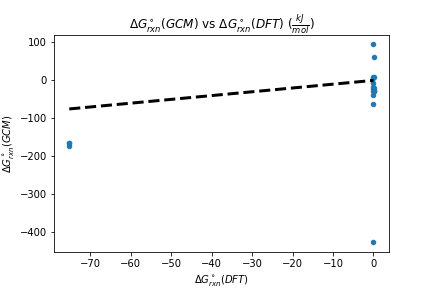

In [3]:
from IPython.display import Image, HTML
Image('Dataset/GCM_vs_QM9.png')

## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')

deltaG.plot(y='$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph) vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
        )

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/MPNNv2_chemgraph_vs_QM9.png')

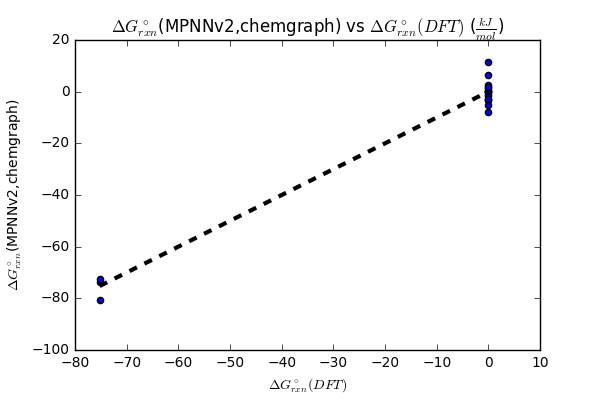

In [4]:
Image('Dataset/MPNNv2_chemgraph_vs_QM9.png')